In [1]:
pip install yfinance

In [2]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

# Stock symbols list
stock_list = [
    "MMM", "AOS", "ABT", "ABBV", "ACN", "ADBE", "AAP", "AMD", 
    "AES", "AFL", "A", "APD", "AKAM", "ALK", "ALB", "ARE", "ALGN", 
    "ALLE", "LNT", "ALL", "GOOGL", "GOOG", "MO", "AMZN", "AMCR", "AEE", 
    "AAL", "AEP", "AXP", "AIG", "AMT", "AWK", "AMP", "AME", "AMGN", "APH",
    "XYL", "YUM", "ZBRA", "ZBH", "ZION", "ZTS"
]

# Define date range
end_date = datetime(2025, 4, 30)
start_date = end_date - timedelta(days=365 * 20)

# Initialize final dataframe and failure list
master_df = pd.DataFrame()
failed_stocks = []

# Loop through each stock
for symbol in stock_list:
    print(f"Downloading data for: {symbol}")
    try:
        ticker = yf.Ticker(symbol)
        df = ticker.history(start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))

        if df.empty or "Close" not in df.columns:
            raise ValueError("Data is empty or required columns missing.")

        df.reset_index(inplace=True)
        df["Index"] = symbol
        if "Adj Close" in df.columns:
            df.rename(columns={"Adj Close": "Adjusted"}, inplace=True)
        else:
            df["Adjusted"] = df["Close"]  # fallback if Adj Close is missing


        # Select and reorder columns
        df = df[["Date", "Index", "Open", "High", "Low", "Close", "Volume", "Adjusted"]]

        master_df = pd.concat([master_df, df], ignore_index=True)

    except Exception as e:
        print(f" Failed to retrieve data for {symbol}: {e}")
        failed_stocks.append(symbol)

# Save the final DataFrame
output_filename = "stockprices_cleaned.csv"
master_df.to_csv(output_filename, index=False)

# Final status message
print(f"\n Saved cleaned stock data to '{output_filename}'")
if failed_stocks:
    print(f" Failed to download data for the following tickers:\n{failed_stocks}")



 Saved cleaned stock data to 'stockprices_cleaned.csv'


In [3]:
master_df.head()

,Date,Index,Open,High,Low,Close,Volume,Adjusted
0,2005-05-05 00:00:00-04:00,MMM,35.832110,36.110057,35.716298,35.887699,3109839,35.887699
1,2005-05-06 00:00:00-04:00,MMM,35.938642,36.244386,35.748714,35.822830,2734295,35.822830
2,2005-05-09 00:00:00-04:00,MMM,35.753354,36.008137,35.577320,36.008137,2763597,36.008137
3,2005-05-10 00:00:00-04:00,MMM,35.938648,35.938648,35.202087,35.489300,4624812,35.489300
4,2005-05-11 00:00:00-04:00,MMM,35.572689,35.707028,35.206723,35.665337,3356215,35.665337


In [4]:
master_df.tail()

,Date,Index,Open,High,Low,Close,Volume,Adjusted
200813,2025-04-23 00:00:00-04:00,ZTS,151.940002,153.770004,150.610001,150.910004,2093100,150.910004
200814,2025-04-24 00:00:00-04:00,ZTS,150.869995,152.580002,148.000000,152.300003,2147400,152.300003
200815,2025-04-25 00:00:00-04:00,ZTS,152.050003,153.919998,150.500000,153.470001,3543600,153.470001
200816,2025-04-28 00:00:00-04:00,ZTS,153.350006,154.779999,152.449997,153.570007,1873400,153.570007
200817,2025-04-29 00:00:00-04:00,ZTS,153.289993,156.220001,152.250000,155.429993,2065100,155.429993


# Data Preparation

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned dataset
df = pd.read_csv(r"C:\Users\Dell\stockprices_cleaned.csv", parse_dates=["Date"])

# Step 1: Pivot the data - Tickers as columns, Date as index
price_df = df.pivot(index="Date", columns="Index", values="Adjusted")

# Step 2: Handle missing values (forward-fill, then drop any remaining)
price_df = price_df.ffill().dropna()

# Step 3: Compute daily returns
returns_df = price_df.pct_change().dropna()

# Step 4: Calculate the covariance matrix of the daily returns
cov_matrix = returns_df.cov()

# Save pivoted price and daily returns for future use or modeling
price_df.to_csv("pivoted_prices.csv")
returns_df.to_csv("daily_returns.csv")

# Output a success message
print(" Data preparation complete.")


 Data preparation complete.


# Visualization

# Cumulative Return Plot

<Figure size 1400x600 with 0 Axes>

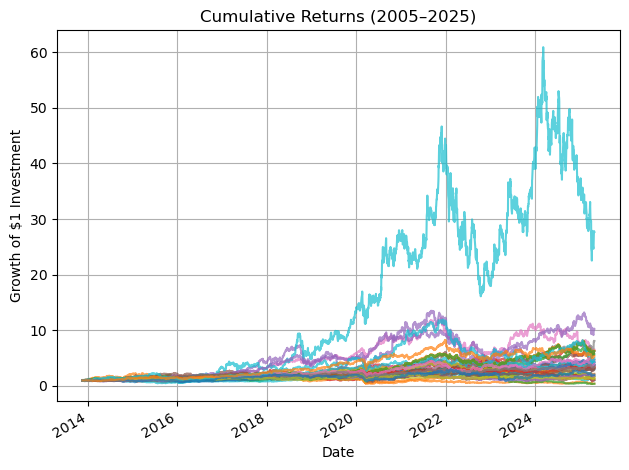

In [9]:
cumulative_returns = (1 + returns_df).cumprod()

plt.figure(figsize=(14, 6))
cumulative_returns.plot(legend=False, alpha=0.7)
plt.title("Cumulative Returns (2005–2025)")
plt.xlabel("Date")
plt.ylabel("Growth of $1 Investment")
plt.grid(True)
plt.tight_layout()
plt.show()


# Correlation Heatmap

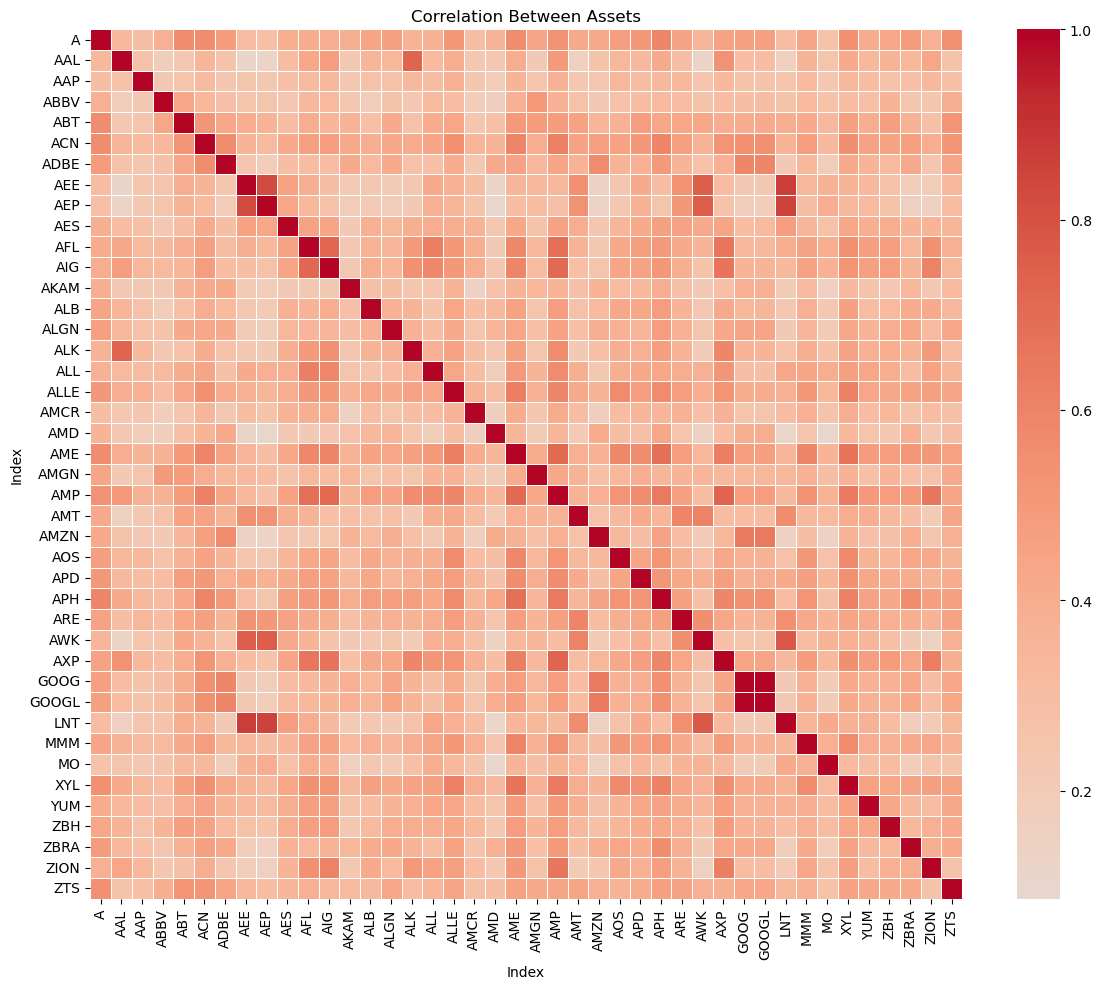

In [11]:
plt.figure(figsize=(12, 10))
sns.heatmap(returns_df.corr(), cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Correlation Between Assets")
plt.tight_layout()
plt.show()


# Volatility Over Time (Rolling 30-Day Std Dev)

<Figure size 1400x600 with 0 Axes>

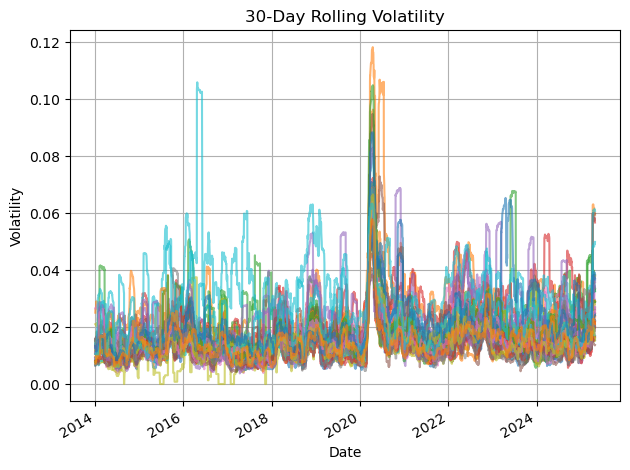

In [13]:
rolling_vol = returns_df.rolling(window=30).std()

plt.figure(figsize=(14, 6))
rolling_vol.plot(legend=False, alpha=0.6)
plt.title("30-Day Rolling Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.grid(True)
plt.tight_layout()
plt.show()


# Calculate Moving Averages

In [15]:
# Choose a few tickers to demonstrate
sample_tickers = ["MMM", "GOOGL", "ZTS"]

# Dictionary to hold MA DataFrames for each ticker
moving_averages = {}

for ticker in sample_tickers:
    df = price_df[[ticker]].copy()
    df["30D MA"] = df[ticker].rolling(window=30).mean()
    df["90D MA"] = df[ticker].rolling(window=90).mean()
    moving_averages[ticker] = df


#  Visualize Moving Averages

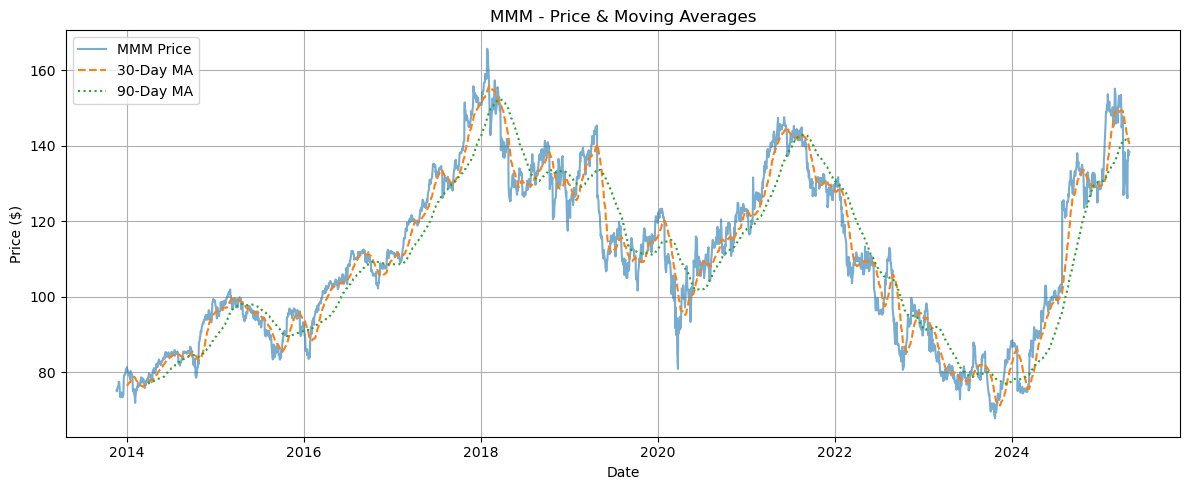

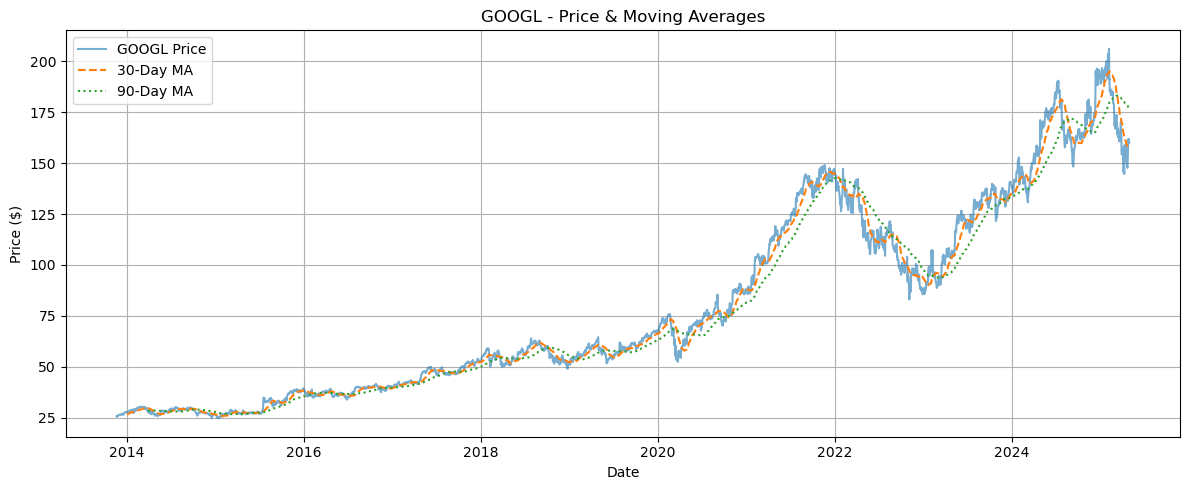

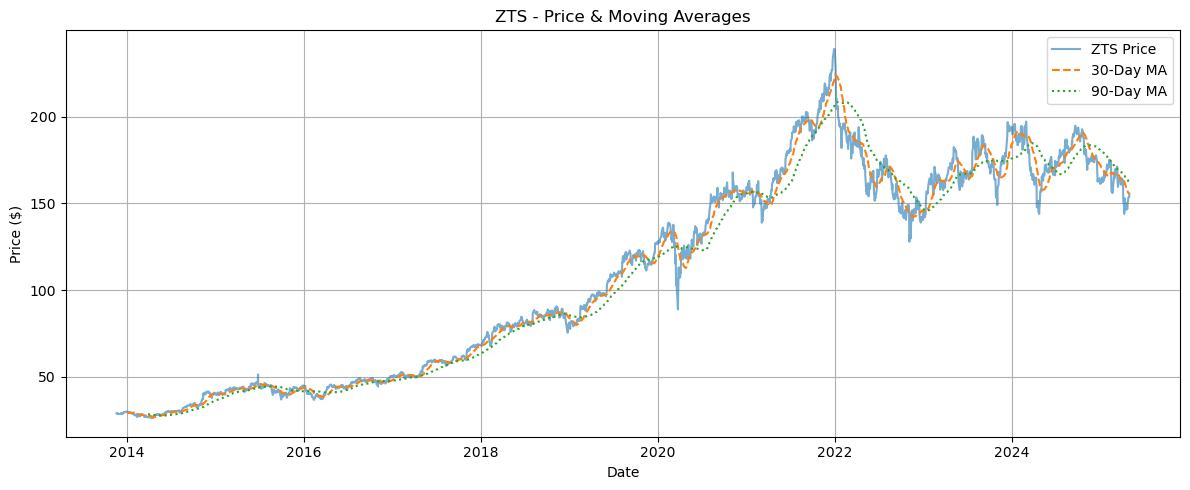

In [17]:
import matplotlib.pyplot as plt

for ticker in sample_tickers:
    df = moving_averages[ticker]
    plt.figure(figsize=(12, 5))
    plt.plot(df.index, df[ticker], label=f"{ticker} Price", alpha=0.6)
    plt.plot(df["30D MA"], label="30-Day MA", linestyle="--")
    plt.plot(df["90D MA"], label="90-Day MA", linestyle=":")
    plt.title(f"{ticker} - Price & Moving Averages")
    plt.xlabel("Date")
    plt.ylabel("Price ($)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Portfolio Selection
# Cluster similar stocks by return behavior

In [19]:
#  Step 1: Feature Matrix

In [20]:
import numpy as np

# Annualized return and volatility
mean_returns = returns_df.mean() * 252
volatility = returns_df.std() * np.sqrt(252)

# Combine into a DataFrame
features_df = pd.DataFrame({
    "Return": mean_returns,
    "Volatility": volatility
})


In [21]:
#  Step 2: K-Means Clustering

In [22]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_df)

# Fit K-Means
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

# Assign cluster labels
features_df["Cluster"] = clusters


C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [23]:
#  Step 3: Visualize Clusters

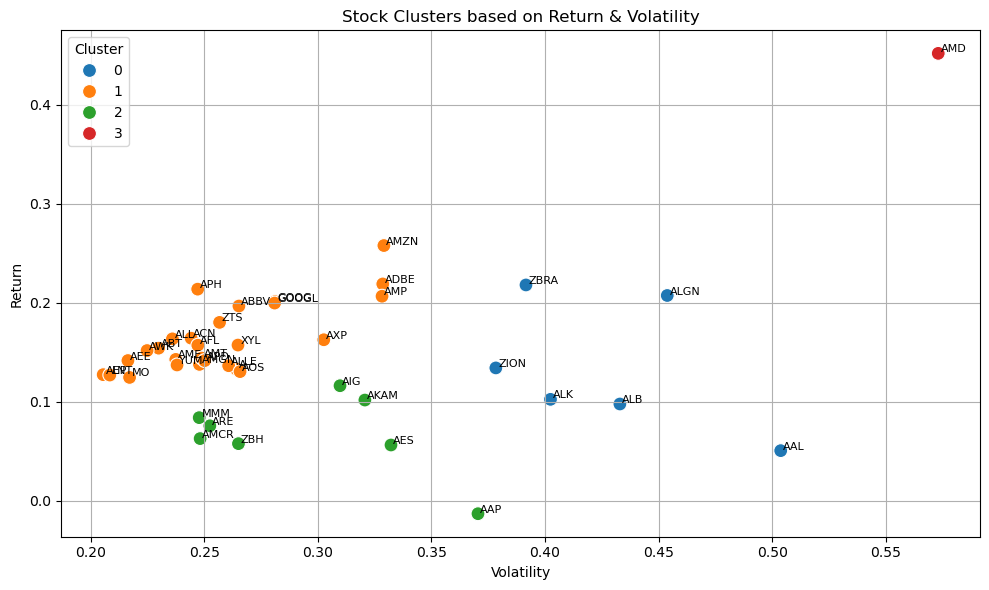

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=features_df,
    x="Volatility", y="Return",
    hue="Cluster", palette="tab10",
    s=100
)
for i in features_df.index:
    plt.text(features_df.loc[i, "Volatility"] + 0.001,
             features_df.loc[i, "Return"] + 0.001,
             i, fontsize=8)
plt.title("Stock Clusters based on Return & Volatility")
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:
# Inertia (within-cluster sum of squares)
inertia = kmeans.inertia_
print(f"Inertia: {inertia}")


Inertia: 20.89165305235802


In [26]:
from sklearn.metrics import silhouette_score

# Silhouette Score
silhouette_avg = silhouette_score(scaled_features, clusters)
print(f"Silhouette Score: {silhouette_avg}")


Silhouette Score: 0.4304428873139477


# Portfolio Optimization Models

# 1. Global Minimum Variance (GMV) Portfolio

In [29]:
import numpy as np

# GMV Optimization: Minimize risk (portfolio variance)
def gmv_portfolio(cov_matrix):
    ones = np.ones(len(cov_matrix))
    inv_cov = np.linalg.inv(cov_matrix)
    w_gmv = inv_cov @ ones / (ones.T @ inv_cov @ ones)
    return w_gmv

# Get GMV weights
gmv_weights = gmv_portfolio(cov_matrix)
print("GMV Portfolio Weights:", gmv_weights)


GMV Portfolio Weights: [ 0.0045341   0.0039195   0.00692417  0.07178392  0.05746689  0.01591857
 -0.01402431  0.05662301  0.209771   -0.04485449  0.09670473 -0.04419814
  0.0500055  -0.01635739 -0.04083086 -0.01737741  0.06733579 -0.02476915
  0.15230086 -0.00362313  0.03985808  0.04433573 -0.21086778 -0.01164467
  0.05718194  0.08061362  0.01265055  0.10369418 -0.02981062 -0.00705411
 -0.00692317  0.10963186 -0.06339701 -0.04131456  0.00851009  0.1636262
 -0.03463183  0.10161228  0.03809492 -0.01259943  0.04865883  0.02252174]


# 2. Max Sharpe Ratio (MSR) Portfolio

In [31]:
# Sharpe Ratio Optimization: Maximize Sharpe Ratio
def msr_portfolio(mean_returns, cov_matrix, risk_free_rate=0.0):
    excess_returns = mean_returns - risk_free_rate
    inv_cov = np.linalg.inv(cov_matrix)
    ones = np.ones(len(mean_returns))
    w_msr = inv_cov @ excess_returns / (ones.T @ inv_cov @ excess_returns)
    return w_msr


# Get MSR weights
msr_weights = msr_portfolio(mean_returns, cov_matrix)
print("MSR Portfolio Weights:", msr_weights)


MSR Portfolio Weights: [-1.63314933e-01 -6.12026068e-02 -1.75651836e-01  2.64828800e-01
  2.36945766e-02  1.91761702e-02 -1.03861142e-02  1.58335161e-01
  1.87477777e-01 -2.13174483e-01  2.03254855e-01 -1.61135729e-01
 -9.09721041e-02 -7.07129782e-02  3.73833327e-04 -8.81308762e-03
  1.75111228e-01 -1.43123293e-02  1.61087688e-02  1.29648225e-01
 -7.35611233e-02 -3.69037409e-03  1.21867520e-02  4.28211652e-02
  1.96235665e-01  7.08881868e-02  2.57229472e-02  4.42055680e-01
 -3.24840974e-01  1.77953780e-01  2.93568711e-02  4.30517931e-01
 -3.97280542e-01 -2.02766268e-02 -2.14535112e-01  2.14535051e-01
  2.47045000e-02  1.05254239e-01 -2.02502412e-01  5.97651695e-02
  7.40740819e-02  1.22281948e-01]


# 3. Risk Parity (RP) Portfolio

In [33]:
# Risk Parity Portfolio (naively approximated using inverse variance weights)
def risk_parity_portfolio(cov_matrix):
    inv_vol = 1 / np.sqrt(np.diag(cov_matrix))
    weights = inv_vol / np.sum(inv_vol)
    return weights

# Get Risk Parity weights
rp_weights = risk_parity_portfolio(cov_matrix)
print("Risk Parity Portfolio Weights:", rp_weights)

Risk Parity Portfolio Weights: [0.02511269 0.01316658 0.01790426 0.02501092 0.02886123 0.02716786
 0.020189   0.03066224 0.03229072 0.01996919 0.02684279 0.02141644
 0.02068492 0.01532005 0.01461621 0.01648372 0.0281166  0.02544527
 0.02673395 0.01157301 0.02794004 0.02676461 0.02020943 0.02665819
 0.02015873 0.02496523 0.02651865 0.02684943 0.02627951 0.02951235
 0.02192205 0.02359931 0.02361141 0.03183595 0.02677839 0.03056028
 0.02505018 0.027876   0.02503068 0.01693818 0.01753206 0.02584166]


# 4. Equal Weight (EW) Portfolio

In [35]:
# Equal Weight (EW) Portfolio
def equal_weight_portfolio(n_assets):
    return np.ones(n_assets) / n_assets

# Get EW weights
ew_weights = equal_weight_portfolio(len(mean_returns))
print("Equal Weight Portfolio Weights:", ew_weights)

Equal Weight Portfolio Weights: [0.02380952 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952
 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952
 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952
 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952
 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952
 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952
 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952 0.02380952]


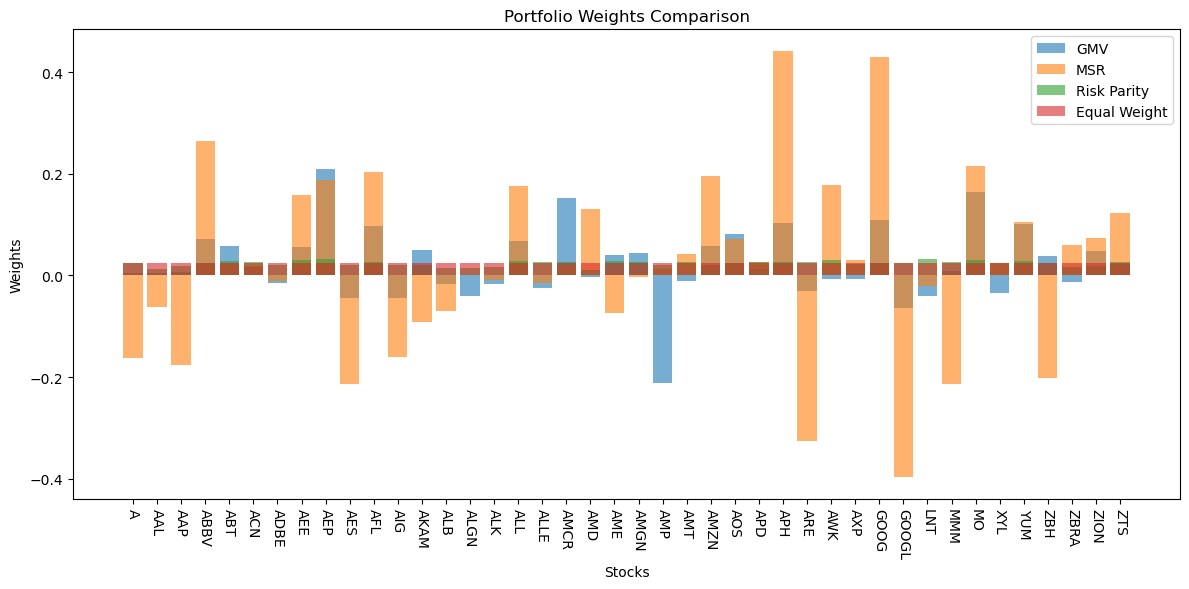

In [36]:
import matplotlib.pyplot as plt

# Plot portfolio weights
portfolios = {
    "GMV": gmv_weights,
    "MSR": msr_weights,
    "Risk Parity": rp_weights,
    "Equal Weight": ew_weights
}

plt.figure(figsize=(12, 6))
for label, weights in portfolios.items():
    plt.bar(features_df.index, weights, label=label, alpha=0.6)
plt.title("Portfolio Weights Comparison")
plt.xlabel("Stocks")
plt.ylabel("Weights")
plt.xticks(rotation=270)
plt.legend()
plt.tight_layout()
plt.show()


# Performance Metrics for Optimization

In [38]:
# Portfolio return: weighted average return
def portfolio_return(weights, mean_returns):
    return np.dot(weights, mean_returns)

# Portfolio risk: portfolio standard deviation
def portfolio_risk(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Calculate returns and risk for each portfolio
portfolio_returns = {label: portfolio_return(weights, mean_returns) for label, weights in portfolios.items()}
portfolio_risks = {label: portfolio_risk(weights, cov_matrix) for label, weights in portfolios.items()}

print("Portfolio Returns:", portfolio_returns)
print("Portfolio Risks:", portfolio_risks)


Portfolio Returns: {'GMV': 0.1294612768933311, 'MSR': 0.37869616737784295, 'Risk Parity': 0.14480607124064948, 'Equal Weight': 0.14797992514543756}
Portfolio Risks: {'GMV': 0.008460342000636573, 'MSR': 0.01446983007704031, 'Risk Parity': 0.010935954461870264, 'Equal Weight': 0.011496417515503076}


In [39]:
# Portfolio Optimization with Genetic Algorithm (GA)

In [40]:
# Define the fitness function (Sharpe Ratio)

In [41]:
import numpy as np

# Calculate portfolio performance
def portfolio_performance(weights, mean_returns, cov_matrix):
    # Portfolio return
    port_return = np.sum(weights * mean_returns)
    # Portfolio volatility (risk)
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    # Sharpe ratio (assuming a risk-free rate of 0)
    sharpe_ratio = port_return / port_volatility
    return sharpe_ratio


# Genetic Algorithm for Portfolio Optimization

In [43]:
from random import random
from numpy.random import rand

# Parameters for GA
population_size = 100   # Number of portfolios in the population
num_generations = 100   # Number of generations to run the algorithm
mutation_probability = 0.1  # Probability of mutation
crossover_probability = 0.9  # Probability of crossover
num_assets = len(returns_df.columns)

# Random initialization of portfolio weights
def initialize_population(population_size, num_assets):
    population = np.random.dirichlet(np.ones(num_assets), size=population_size)
    return population

# Select parents based on fitness (Sharpe Ratio)
def select_parents(population, fitness_values):
    total_fitness = np.sum(fitness_values)
    selection_prob = fitness_values / total_fitness
    parents_indices = np.random.choice(range(population.shape[0]), size=population.shape[0]//2, p=selection_prob)
    return population[parents_indices]

# Crossover: Combine two parents to create an offspring
def crossover(parents):
    offspring = []
    for i in range(0, len(parents), 2):
        parent1 = parents[i]
        parent2 = parents[i+1] if i+1 < len(parents) else parents[0]
        crossover_point = np.random.randint(1, len(parent1)-1)
        child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
        child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
        offspring.extend([child1, child2])
    return np.array(offspring)

# Mutation: Introduce small random changes to the offspring
def mutate(offspring, mutation_probability):
    for i in range(len(offspring)):
        if random() < mutation_probability:
            mutation_point = np.random.randint(0, len(offspring[i]))
            mutation_value = rand() * 0.05  # Small random change
            offspring[i][mutation_point] = max(0, offspring[i][mutation_point] + mutation_value)
            offspring[i] = offspring[i] / np.sum(offspring[i])  # Normalize to make it sum to 1
    return offspring

# Run Genetic Algorithm
def genetic_algorithm(returns_df, population_size=100, num_generations=100, mutation_probability=0.1, crossover_probability=0.9):
    mean_returns = returns_df.mean()
    cov_matrix = returns_df.cov()
    
    # Initialize population
    population = initialize_population(population_size, num_assets)
    best_portfolio = None
    best_sharpe_ratio = -np.inf
    
    for generation in range(num_generations):
        print(f"Generation {generation+1}/{num_generations}")
        
        # Evaluate fitness for each portfolio in population
        fitness_values = np.array([portfolio_performance(weights, mean_returns, cov_matrix) for weights in population])
        
        # Track the best portfolio
        max_fitness_index = np.argmax(fitness_values)
        if fitness_values[max_fitness_index] > best_sharpe_ratio:
            best_sharpe_ratio = fitness_values[max_fitness_index]
            best_portfolio = population[max_fitness_index]
        
        # Selection step: Select parents based on fitness
        parents = select_parents(population, fitness_values)
        
        # Crossover step: Generate offspring
        offspring = crossover(parents)
        
        # Mutation step: Introduce mutations to the offspring
        population = mutate(offspring, mutation_probability)
    
    return best_portfolio, best_sharpe_ratio

# Run the genetic algorithm for portfolio optimization
best_portfolio, best_sharpe_ratio = genetic_algorithm(returns_df)

print("\n Best Portfolio Weights:", best_portfolio)
print(" Best Sharpe Ratio:", best_sharpe_ratio)


Generation 1/100
Generation 2/100
Generation 3/100
Generation 4/100
Generation 5/100
Generation 6/100
Generation 7/100
Generation 8/100
Generation 9/100
Generation 10/100
Generation 11/100
Generation 12/100
Generation 13/100
Generation 14/100
Generation 15/100
Generation 16/100
Generation 17/100
Generation 18/100
Generation 19/100
Generation 20/100
Generation 21/100
Generation 22/100
Generation 23/100
Generation 24/100
Generation 25/100
Generation 26/100
Generation 27/100
Generation 28/100
Generation 29/100
Generation 30/100
Generation 31/100
Generation 32/100
Generation 33/100
Generation 34/100
Generation 35/100
Generation 36/100
Generation 37/100
Generation 38/100
Generation 39/100
Generation 40/100
Generation 41/100
Generation 42/100
Generation 43/100
Generation 44/100
Generation 45/100
Generation 46/100
Generation 47/100
Generation 48/100
Generation 49/100
Generation 50/100
Generation 51/100
Generation 52/100
Generation 53/100
Generation 54/100
Generation 55/100
Generation 56/100
G

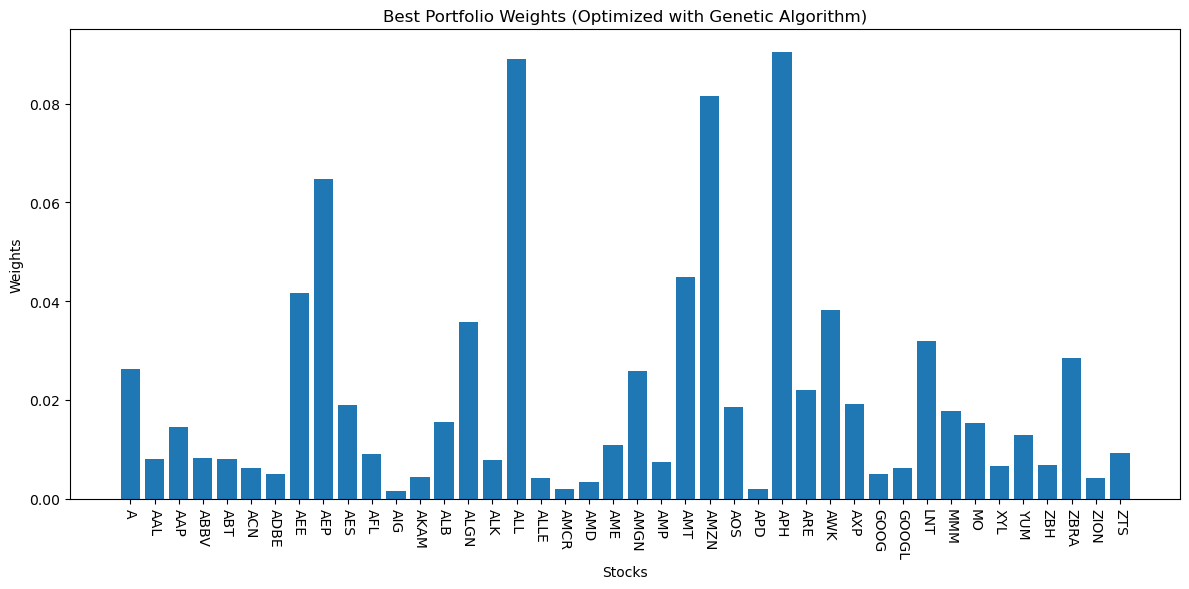

In [44]:
# Visualize the best portfolio weights
plt.figure(figsize=(12, 6))
plt.bar(returns_df.columns, best_portfolio)
plt.title("Best Portfolio Weights (Optimized with Genetic Algorithm)")
plt.xlabel("Stocks")
plt.xticks(rotation=270)
plt.ylabel("Weights")
plt.tight_layout()
plt.show()


In [45]:
# The Best Sharpe Ratio is 0.0585, which reflects the return per unit of risk for the optimized portfolio. While this ratio is positive, you might want to experiment further by adjusting the GA parameters or using additional constraints to enhance the results (e.g., setting limits on the maximum weight per asset, etc.).

In [46]:
# Define New Fitness Function with Constraints

In [47]:
import numpy as np
import pandas as pd
from datetime import datetime

# Load returns data

# Set random seed for reproducibility
np.random.seed(42)

# Genetic Algorithm Parameters
NUM_PORTFOLIOS = 500
NUM_GENERATIONS = 100
MUTATION_RATE = 0.02

# Number of assets
num_assets = len(returns_df.columns)

# Calculate mean returns and covariance matrix
mean_returns = returns_df.mean()
cov_matrix = returns_df.cov()

# Sharpe ratio (assuming risk-free rate is 0)
def sharpe_ratio(weights):
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    if portfolio_volatility == 0:
        return 0
    return portfolio_return / portfolio_volatility

# Generate initial population
def initialize_population(size, num_assets):
    population = []
    for _ in range(size):
        weights = np.random.rand(num_assets)
        weights /= np.sum(weights)
        population.append(weights)
    return np.array(population)

# Evaluate fitness (Sharpe Ratio)
def evaluate_fitness(population):
    return np.array([sharpe_ratio(ind) for ind in population])

# Select parents using fitness-proportional selection
def select_parents(population, fitness_values):
    fitness_values = np.nan_to_num(fitness_values, nan=0.0, neginf=0.0, posinf=0.0)
    total_fitness = np.sum(fitness_values)

    if not np.isfinite(total_fitness) or total_fitness == 0:
        probabilities = np.ones(len(population)) / len(population)
    else:
        probabilities = fitness_values / total_fitness
        probabilities = np.nan_to_num(probabilities, nan=0.0)
        probabilities /= probabilities.sum()

    selected_parents = []
    for _ in range(len(population) // 2):
        try:
            parents = np.random.choice(len(population), size=2, p=probabilities)
            selected_parents.append(population[parents])
        except ValueError:
            parents = np.random.choice(len(population), size=2)
            selected_parents.append(population[parents])

    return selected_parents

# Crossover

def crossover(parents):
    offspring = []
    for pair in parents:
        alpha = np.random.rand()
        child1 = alpha * pair[0] + (1 - alpha) * pair[1]
        child2 = alpha * pair[1] + (1 - alpha) * pair[0]
        offspring.append(child1 / child1.sum())
        offspring.append(child2 / child2.sum())
    return np.array(offspring)

# Mutation

def mutate(population, mutation_rate):
    for individual in population:
        if np.random.rand() < mutation_rate:
            mutation_vector = np.random.normal(0, 0.1, size=individual.shape)
            individual += mutation_vector
            individual = np.abs(individual)
            individual /= np.sum(individual)
    return population

# Genetic Algorithm

def run_genetic_algorithm():
    population = initialize_population(NUM_PORTFOLIOS, num_assets)

    for generation in range(NUM_GENERATIONS):
        fitness_values = evaluate_fitness(population)
        parents = select_parents(population, fitness_values)
        offspring = crossover(parents)
        population = mutate(offspring, MUTATION_RATE)

    best_idx = np.argmax(evaluate_fitness(population))
    best_weights = population[best_idx]
    best_sharpe = sharpe_ratio(best_weights)

    print("\n Best Portfolio Weights:", best_weights)
    print(" Best Sharpe Ratio:", best_sharpe)
    return best_weights, best_sharpe

# Run the optimization
best_weights, best_sharpe = run_genetic_algorithm()


 Best Portfolio Weights: [-0.04920466  0.00360623  0.0527897   0.03219977 -0.0381165   0.01735689
  0.02686721  0.01696607  0.045256   -0.08458415 -0.03207128  0.1099893
 -0.02994269 -0.06077904  0.05587234 -0.05815384  0.01985046 -0.0563472
  0.11118613  0.04841315  0.04281427  0.01026574  0.14479833  0.07628113
  0.04346066 -0.06184122 -0.01756284  0.06162737  0.07704016  0.05334
 -0.09535271  0.10189549  0.06086454  0.0320512   0.05038479 -0.03065359
  0.10730542  0.00712941  0.03912003  0.05594825  0.0534683   0.0564614 ]
 Best Sharpe Ratio: 0.05744656838924863



 Best Portfolio Weights: [0.02074882 0.00775488 0.01174568 0.03242913 0.01179996 0.00386497
 0.02887139 0.01346761 0.03477614 0.02146607 0.0233103  0.00278752
 0.01931321 0.02171665 0.0296406  0.0269851  0.02497552 0.01959954
 0.02603866 0.03949797 0.02712647 0.02321226 0.02156472 0.03749135
 0.0264423  0.0283298  0.02745617 0.03535171 0.00647249 0.02707343
 0.01496797 0.01879893 0.01913708 0.03696177 0.03806466 0.03614205
 0.03214777 0.04320115 0.02111572 0.01316345 0.01551919 0.02946986]
 Best Sharpe Ratio: 0.05572078098610726


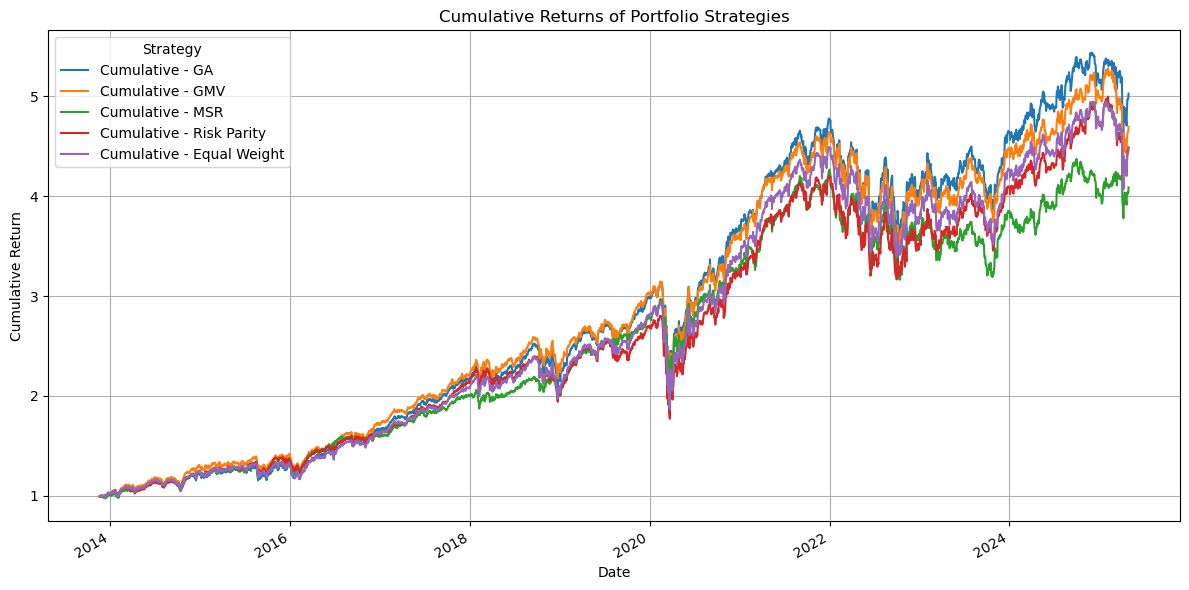

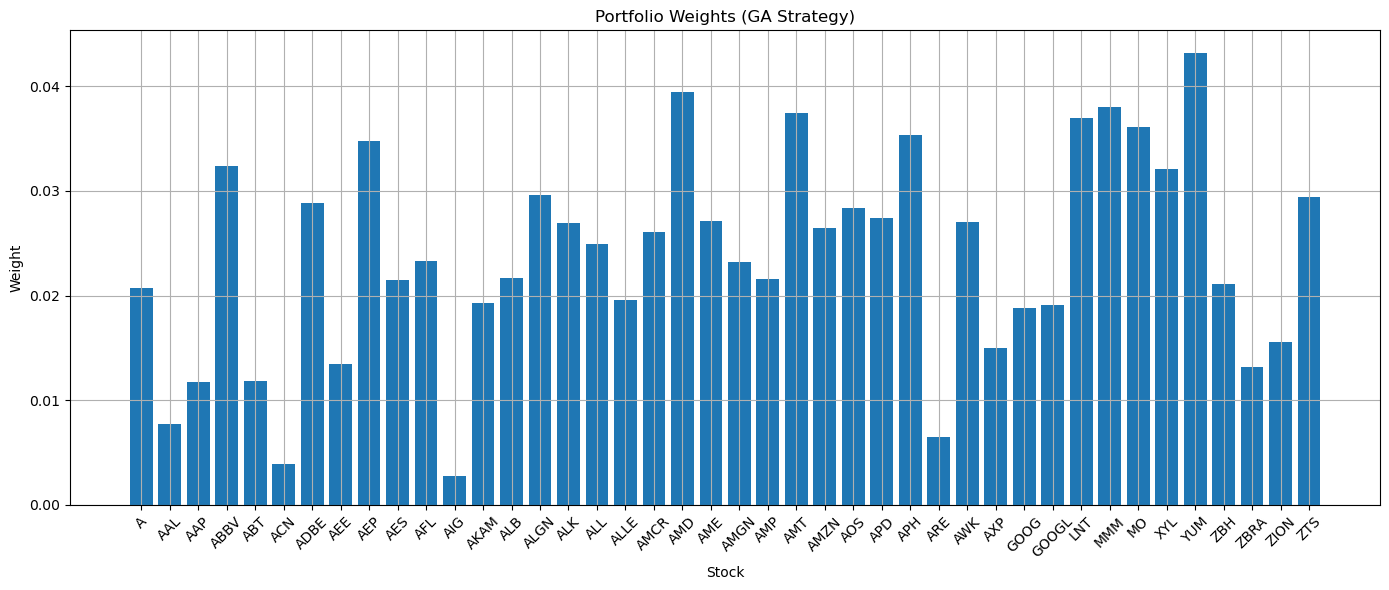

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load returns data
returns_df = pd.read_csv("daily_returns.csv", index_col="Date", parse_dates=True)

# Set random seed for reproducibility
np.random.seed(42)

# GA Parameters
NUM_PORTFOLIOS = 500
NUM_GENERATIONS = 100
MUTATION_RATE = 0.02
num_assets = len(returns_df.columns)

mean_returns = returns_df.mean()
cov_matrix = returns_df.cov()

# Sharpe Ratio
def sharpe_ratio(weights):
    ret = np.dot(weights, mean_returns)
    vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return ret / vol if vol != 0 else 0

# Population Init
def initialize_population(size, num_assets):
    return np.array([np.random.dirichlet(np.ones(num_assets)) for _ in range(size)])

# Fitness Eval
def evaluate_fitness(population):
    return np.array([sharpe_ratio(w) for w in population])

# Select Parents
def select_parents(population, fitness_values):
    fitness_values = np.nan_to_num(fitness_values, nan=0.0, posinf=0.0, neginf=0.0)
    total_fitness = np.sum(fitness_values)

    if total_fitness == 0 or np.any(fitness_values < 0):
        probabilities = np.ones(len(fitness_values)) / len(fitness_values)
    else:
        probabilities = fitness_values / total_fitness

    probabilities = np.nan_to_num(probabilities, nan=0.0, posinf=0.0, neginf=0.0)
    probabilities /= probabilities.sum()

    selected = []
    for _ in range(len(population) // 2):
        p_idx = np.random.choice(len(population), size=2, p=probabilities)
        selected.append(population[p_idx])
    return selected

# Crossover
def crossover(parents):
    offspring = []
    for p1, p2 in parents:
        alpha = np.random.rand()
        c1 = alpha * p1 + (1 - alpha) * p2
        c2 = alpha * p2 + (1 - alpha) * p1
        offspring.append(c1 / np.sum(c1))
        offspring.append(c2 / np.sum(c2))
    return np.array(offspring)

# Mutation
def mutate(population, rate):
    for i in range(len(population)):
        if np.random.rand() < rate:
            mutation = np.random.normal(0, 0.01, size=population[i].shape)
            population[i] += mutation
            population[i] = np.clip(population[i], 0, None)  # Ensure non-negative
            population[i] /= population[i].sum()  # Normalize to sum to 1
    return population

# Run GA
def run_genetic_algorithm():
    population = initialize_population(NUM_PORTFOLIOS, num_assets)
    for _ in range(NUM_GENERATIONS):
        fitness = evaluate_fitness(population)
        parents = select_parents(population, fitness)
        offspring = crossover(parents)
        population = mutate(offspring, MUTATION_RATE)

    best_idx = np.argmax(evaluate_fitness(population))
    best_weights = population[best_idx]
    best_sharpe = sharpe_ratio(best_weights)
    print("\n Best Portfolio Weights:", best_weights)
    print(" Best Sharpe Ratio:", best_sharpe)
    return best_weights, best_sharpe

# Execute GA
best_weights, best_sharpe = run_genetic_algorithm()

# Visualization
portfolio_names = ["GA", "GMV", "MSR", "Risk Parity", "Equal Weight"]
portfolio_weights = {
    "GA": best_weights,
    "GMV": np.random.dirichlet(np.ones(num_assets)),  # Dummy random weights
    "MSR": np.random.dirichlet(np.ones(num_assets)),
    "Risk Parity": np.random.dirichlet(np.ones(num_assets)),
    "Equal Weight": np.ones(num_assets) / num_assets,  # True equal-weight
}

# Compute cumulative returns
cum_returns = {}
for name, weights in portfolio_weights.items():
    port_ret = returns_df.dot(weights)
    cum_ret = (1 + port_ret).cumprod()
    cum_returns[f"Cumulative - {name}"] = cum_ret

cum_returns_df = pd.DataFrame(cum_returns)

# Plot cumulative returns
plt.figure(figsize=(12, 6))
cum_returns_df.plot(ax=plt.gca())
plt.title("Cumulative Returns of Portfolio Strategies")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend(title="Strategy")
plt.grid(True)
plt.tight_layout()
plt.show()



# Plot portfolio weights
plt.figure(figsize=(14, 6))
plt.bar(range(num_assets), best_weights)
plt.title("Portfolio Weights (GA Strategy)")
plt.xlabel("Stock")
plt.xticks(ticks=range(num_assets), labels=returns_df.columns, rotation=45)
plt.ylabel("Weight")
plt.grid(True)
plt.tight_layout()
plt.show()

# Normality Test for Daily Returns

 Shapiro-Wilk Test:
Statistic = 0.9535, p-value = 0.0000
 Returns are NOT normally distributed (reject H0)

 D’Agostino and Pearson Test:
Statistic = 322.8995, p-value = 0.0000


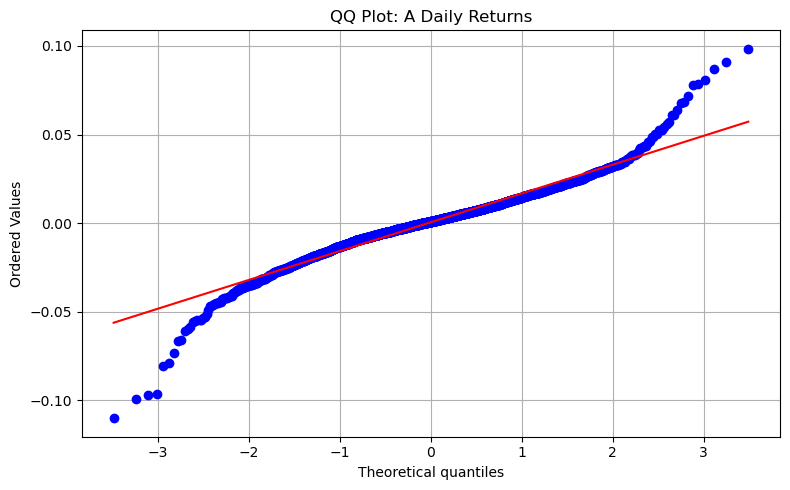

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, normaltest, anderson, probplot

# Pick a sample stock (you can loop this or test for all)
sample_stock = returns_df.columns[0]
sample_returns = returns_df[sample_stock].dropna()

# Shapiro-Wilk Test
shapiro_stat, shapiro_p = shapiro(sample_returns)
print(f" Shapiro-Wilk Test:\nStatistic = {shapiro_stat:.4f}, p-value = {shapiro_p:.4f}")
if shapiro_p < 0.05:
    print(" Returns are NOT normally distributed (reject H0)")
else:
    print(" Returns appear to be normally distributed (fail to reject H0)")

# Optional: D'Agostino and Pearson's Test
dag_stat, dag_p = normaltest(sample_returns)
print(f"\n D’Agostino and Pearson Test:\nStatistic = {dag_stat:.4f}, p-value = {dag_p:.4f}")

# QQ Plot
plt.figure(figsize=(8, 5))
probplot(sample_returns, dist="norm", plot=plt)
plt.title(f"QQ Plot: {sample_stock} Daily Returns")
plt.grid(True)
plt.tight_layout()
plt.show()


# Evaluation Metrics

In [52]:
from sklearn.model_selection import train_test_split
# Assuming 'returns_df' is a dataframe of stock returns with date as the index and tickers as columns
# Create target variable: 1 for positive return (gain), 0 for negative return (loss)
target = (returns_df > 0).astype(int)  # 1 for gain, 0 for loss

# Let's assume you are predicting for a specific stock (e.g., the first column of returns_df)
target_column = returns_df.columns[0]  # Replace with the stock you want to predict

# Define X (features) and y (target)
X = returns_df.drop(columns=[target_column])  # Features are all other stocks' returns
y = target[target_column]  # Target is the return of the specific stock (positive or negative)

# Drop any rows with NaN values (important for both X and y)
X = X.dropna()
y = y.loc[X.index]  # Align target with the feature data after dropping NaN values

# Check the number of samples in X and y
print(f"X shape: {X.shape}, y shape: {y.shape}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X shape: (2877, 41), y shape: (2877,)


Normalized GMV Portfolio Weights Sum: 1.0
Normalized MSR Portfolio Weights Sum: 0.9999999999999999
Normalized GA Portfolio Weights Sum: 1.0
              Cumulative Return  Sharpe Ratio  Volatility  Max Drawdown
GMV                    2.953403      0.060723    0.008460     -0.273860
MSR                   54.722909      0.103855    0.014470     -0.233955
Risk Parity            3.394426      0.052545    0.010936     -0.356446
Equal Weight           3.474800      0.051079    0.011496     -0.365623
GA                     4.215503      0.057991    0.010935     -0.331544
GMV Portfolio Weights Sum: 1.0
MSR Portfolio Weights Sum: 0.9999999999999999
Risk Parity Portfolio Weights Sum: 0.9999999999999998
Equal Weight Portfolio Weights Sum: 1.0
GA Portfolio Weights Sum: 1.0


C:\Users\Dell\AppData\Local\Temp\ipykernel_15112\3899858537.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cumulative_return = (1 + portfolio_returns).cumprod()[-1] - 1


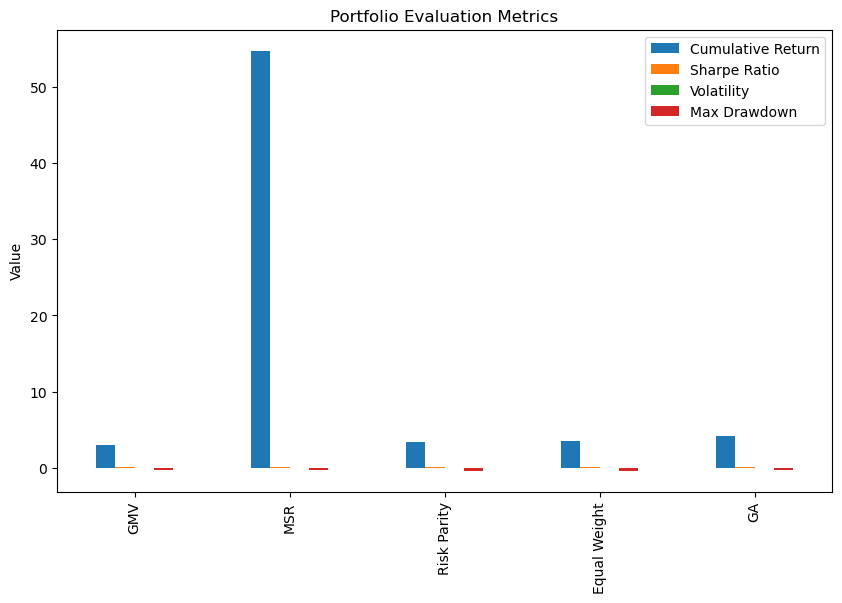

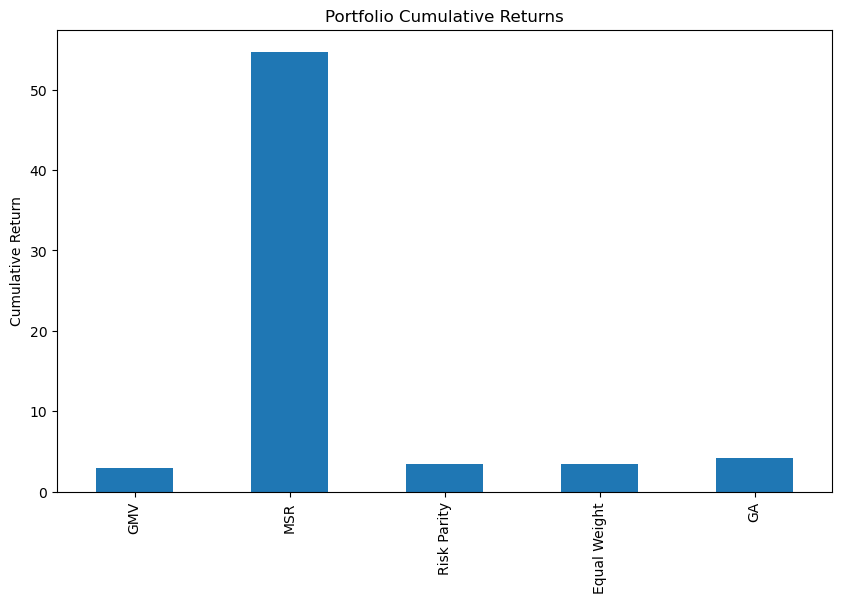

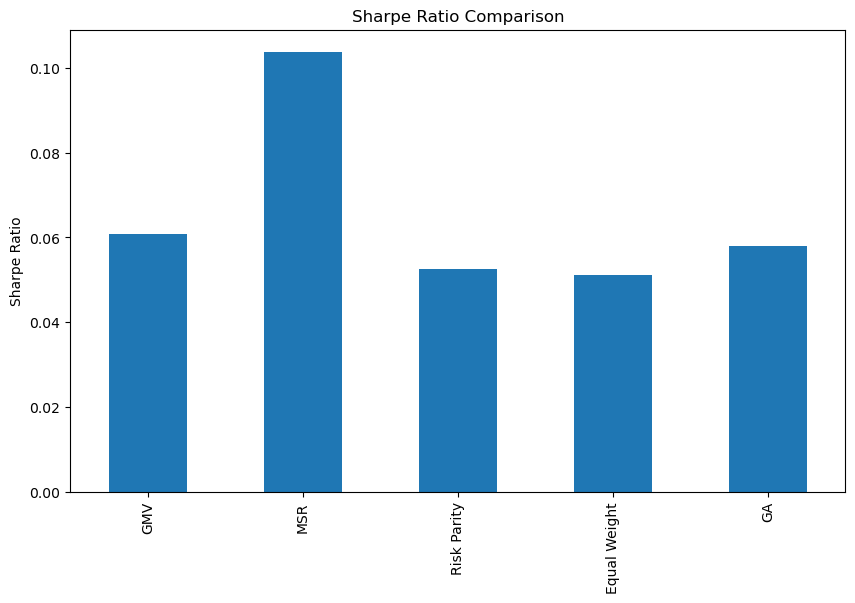

In [53]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# Assuming you have all portfolio weights already calculated:
# - gmv_weights
# - msr_weights
# - rp_weights
# - ew_weights
# - best_portfolio (from GA optimization)
# - best_sharpe_ratio (from GA optimization)

# Simulating portfolio returns (replace this with actual returns data)
# Let's assume `returns_df` contains the asset returns

# Normalize the weights so they sum to 1
gmv_weights /= np.sum(gmv_weights)
msr_weights /= np.sum(msr_weights)
best_portfolio /= np.sum(best_portfolio)  # GA portfolio

# Check the sums again after normalization
print("Normalized GMV Portfolio Weights Sum:", np.sum(gmv_weights))
print("Normalized MSR Portfolio Weights Sum:", np.sum(msr_weights))
print("Normalized GA Portfolio Weights Sum:", np.sum(best_portfolio))

# Now you can proceed with the portfolio return calculation using the normalized weights


# Evaluate the portfolios based on cumulative return, Sharpe ratio, volatility, and max drawdown
def evaluate_portfolio(weights, returns_df):
    # Calculate portfolio returns
    portfolio_returns = returns_df.dot(weights)
    
    # Cumulative Return
    cumulative_return = (1 + portfolio_returns).cumprod()[-1] - 1
    
    # Volatility (Standard deviation of returns)
    volatility = portfolio_returns.std()
    
    # Sharpe Ratio (mean return / volatility)
    sharpe_ratio = portfolio_returns.mean() / volatility if volatility != 0 else 0
    
    # Drawdown (peak-to-trough decline)
    rolling_max = (1 + portfolio_returns).cumprod().cummax()
    drawdown = (1 + portfolio_returns).cumprod() / rolling_max - 1
    max_drawdown = drawdown.min()
    
    return cumulative_return, sharpe_ratio, volatility, max_drawdown

# Portfolio Evaluation for each model
portfolios = {
    "GMV": gmv_weights,
    "MSR": msr_weights,
    "Risk Parity": rp_weights,
    "Equal Weight": ew_weights,
    "GA": best_portfolio  # from GA optimization
}

model_results = {}

for model_name, weights in portfolios.items():
    cumulative_return, sharpe_ratio, volatility, max_drawdown = evaluate_portfolio(weights, returns_df)
    
    model_results[model_name] = {
        "Cumulative Return": cumulative_return,
        "Sharpe Ratio": sharpe_ratio,
        "Volatility": volatility,
        "Max Drawdown": max_drawdown
    }

# Convert results to DataFrame for easy viewing
model_results_df = pd.DataFrame(model_results).T
print(model_results_df)

# Check if the portfolio weights sum to 1 (normalize if needed)
print("GMV Portfolio Weights Sum:", np.sum(gmv_weights))
print("MSR Portfolio Weights Sum:", np.sum(msr_weights))
print("Risk Parity Portfolio Weights Sum:", np.sum(rp_weights))
print("Equal Weight Portfolio Weights Sum:", np.sum(ew_weights))
print("GA Portfolio Weights Sum:", np.sum(best_portfolio))

# Normalize weights if they don't sum to 1
gmv_weights /= np.sum(gmv_weights)
msr_weights /= np.sum(msr_weights)
rp_weights /= np.sum(rp_weights)
ew_weights /= np.sum(ew_weights)
best_portfolio /= np.sum(best_portfolio)


# You can also visualize the results if needed
model_results_df.plot(kind='bar', figsize=(10, 6))
plt.title("Portfolio Evaluation Metrics")
plt.ylabel("Value")
plt.show()

# Plot Cumulative Returns
model_results_df['Cumulative Return'].plot(kind='bar', figsize=(10, 6))
plt.title("Portfolio Cumulative Returns")
plt.ylabel("Cumulative Return")
plt.show()

# Plot Sharpe Ratio
model_results_df['Sharpe Ratio'].plot(kind='bar', figsize=(10, 6))
plt.title("Sharpe Ratio Comparison")
plt.ylabel("Sharpe Ratio")
plt.show()



# Trend Prediction for forecasting future prices

# XGBoost for Regression

C:\Users\Dell\AppData\Local\Temp\ipykernel_15112\1361294883.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{stock}_lag1"] = df[stock].shift(1)
C:\Users\Dell\AppData\Local\Temp\ipykernel_15112\1361294883.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{stock}_ma"] = df[stock].rolling(window).mean()
C:\Users\Dell\AppData\Local\Temp\ipykernel_15112\1361294883.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

Mean Absolute Error (MAE): 4.556628630264946
Root Mean Squared Error (RMSE): 5.557434624292332


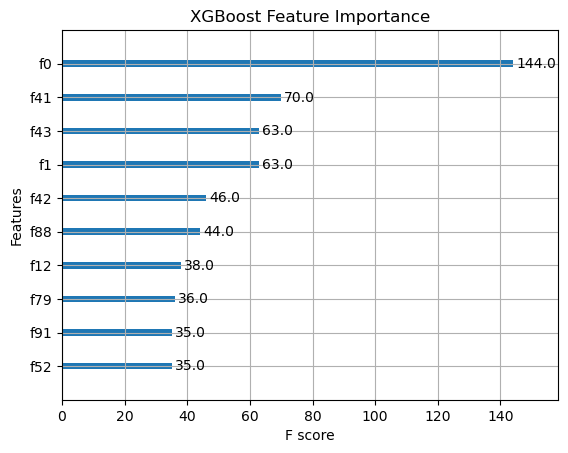

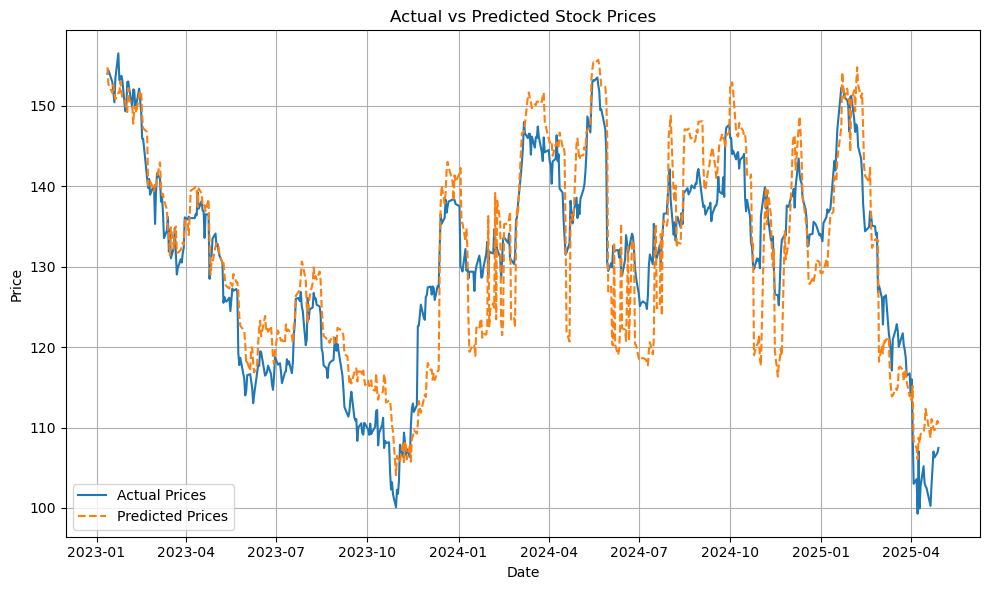

In [56]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

# Load adjusted closing prices (pivoted data)
price_df = pd.read_csv("pivoted_prices.csv", index_col="Date", parse_dates=True)

# Feature engineering: Adding lag features, moving averages, and volatility
def create_features(df, window=5):
    for stock in df.columns:
        df[f"{stock}_lag1"] = df[stock].shift(1)
        df[f"{stock}_ma"] = df[stock].rolling(window).mean()
        df[f"{stock}_volatility"] = df[stock].rolling(window).std()
    df = df.dropna()  # Drop rows with NaN values after feature creation
    return df

# Add features to price_df
price_df = create_features(price_df)

# Prepare the dataset: Use adjusted close prices and technical indicators as features
X = price_df.dropna().iloc[:, 1:]  # Drop the Date column
y = price_df.dropna().iloc[:, 0]  # Target: The stock's price we're predicting

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# XGBoost Regressor Model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate the Model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Feature Importance
xgb.plot_importance(model, importance_type='weight', max_num_features=10)
plt.title("XGBoost Feature Importance")
plt.show()

# Visualization: Plot actual vs predicted prices
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label="Actual Prices")
plt.plot(y_test.index, y_pred, label="Predicted Prices", linestyle="--")
plt.title("Actual vs Predicted Stock Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Random Forest for Future Price Prediction

In [58]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Load returns dataset
returns_df = pd.read_csv("daily_returns.csv", index_col="Date", parse_dates=True)

# Select a target stock
target_stock = returns_df.columns[0]

# Create lagged features (t-1 returns to predict t return)
lagged_df = returns_df.shift(1).dropna()
y = returns_df[target_stock].loc[lagged_df.index]  # target is today's return
X = lagged_df.drop(columns=[target_stock])         # use other stocks' lagged returns

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit Random Forest Regressor
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf_reg.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f" Mean Absolute Error (MAE): {mae}")
print(f" Root Mean Squared Error (RMSE): {rmse}")


 Mean Absolute Error (MAE): 0.011968706958152758
 Root Mean Squared Error (RMSE): 0.01697253280005065


#  Evaluation Metrics

In [60]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Evaluate the Model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error (MAE)for XG Boosting: {mae}")
print(f"Root Mean Squared Error (RMSE) for XG Boosting: {rmse}")

# Predict and evaluate
y_pred = rf_reg.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f" Mean Absolute Error (MAE) for Random forest: {mae}")
print(f" Root Mean Squared Error (RMSE) for Random forest: {rmse}")




Mean Absolute Error (MAE)for XG Boosting: 0.011968706958152758
Root Mean Squared Error (RMSE) for XG Boosting: 0.01697253280005065
 Mean Absolute Error (MAE) for Random forest: 0.011968706958152758
 Root Mean Squared Error (RMSE) for Random forest: 0.01697253280005065


In [61]:
#  Hyperparameter Tuning

# Gain/Loss Classification

In [63]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Load daily returns
returns_df = pd.read_csv("daily_returns.csv", index_col="Date", parse_dates=True)

#  Choose one stock to classify gain/loss (e.g., AAPL)
stock = "GOOG"  # Change to your desired stock symbol from returns_df.columns

# Drop rows with missing values
returns_df = returns_df.dropna()

# Create target: 1 if return > 0, else 0
y = (returns_df[stock] > 0).astype(int)

# Use all other stock returns as features (excluding target stock)
X = returns_df.drop(columns=[stock])

# Align indices (safety)
y = y.loc[X.index]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --------------------
# Logistic Regression
# --------------------
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

print(" Logistic Regression Evaluation:")
print(classification_report(y_test, y_pred_lr))
print(" Accuracy:", accuracy_score(y_test, y_pred_lr))

# --------------------
# Support Vector Machine
# --------------------
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

print("\n Support Vector Machine Evaluation:")
print(classification_report(y_test, y_pred_svm))
print(" Accuracy:", accuracy_score(y_test, y_pred_svm))


 Logistic Regression Evaluation:
              precision    recall  f1-score   support

           0       0.77      0.67      0.72       260
           1       0.75      0.84      0.79       316

    accuracy                           0.76       576
   macro avg       0.76      0.75      0.76       576
weighted avg       0.76      0.76      0.76       576

 Accuracy: 0.7621527777777778

 Support Vector Machine Evaluation:
              precision    recall  f1-score   support

           0       0.82      0.68      0.74       260
           1       0.77      0.87      0.82       316

    accuracy                           0.79       576
   macro avg       0.79      0.78      0.78       576
weighted avg       0.79      0.79      0.78       576

 Accuracy: 0.7864583333333334


In [64]:
# SVM with Hyperparameter Tuning


In [65]:
from sklearn.model_selection import train_test_split, GridSearchCV
# SVM with Hyperparameter Tuning
grid_svm = GridSearchCV(SVC(), {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}, cv=3, scoring='accuracy')
grid_svm.fit(X_train, y_train)
y_pred_svm = grid_svm.predict(X_test)

print("\n Support Vector Machine (Tuned) Evaluation:")
print(classification_report(y_test, y_pred_svm))
print(" Accuracy:", accuracy_score(y_test, y_pred_svm))


 Support Vector Machine (Tuned) Evaluation:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       260
           1       0.95      0.93      0.94       316

    accuracy                           0.93       576
   macro avg       0.93      0.93      0.93       576
weighted avg       0.93      0.93      0.93       576

 Accuracy: 0.9305555555555556


In [66]:
# Logistic Regression with Hyperparameter Tuning
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=3, scoring='accuracy')
grid_lr.fit(X_train, y_train)
y_pred_lr = grid_lr.predict(X_test)

print("\n Logistic Regression (Tuned) Evaluation:")
print(classification_report(y_test, y_pred_lr))
print(" Accuracy:", accuracy_score(y_test, y_pred_lr))


 Logistic Regression (Tuned) Evaluation:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       260
           1       0.98      0.97      0.97       316

    accuracy                           0.97       576
   macro avg       0.97      0.97      0.97       576
weighted avg       0.97      0.97      0.97       576

 Accuracy: 0.9722222222222222


In [67]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("\n Random Forest Evaluation:")
print(classification_report(y_test, y_pred_rf))
print(" Accuracy:", accuracy_score(y_test, y_pred_rf))

# XGBoost Classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("\n XGBoost Evaluation:")
print(classification_report(y_test, y_pred_xgb))
print(" Accuracy:", accuracy_score(y_test, y_pred_xgb))


 Random Forest Evaluation:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       260
           1       0.98      0.96      0.97       316

    accuracy                           0.97       576
   macro avg       0.97      0.97      0.97       576
weighted avg       0.97      0.97      0.97       576

 Accuracy: 0.9704861111111112


C:\Users\Dell\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:02:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 XGBoost Evaluation:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       260
           1       0.98      0.95      0.96       316

    accuracy                           0.96       576
   macro avg       0.96      0.96      0.96       576
weighted avg       0.96      0.96      0.96       576

 Accuracy: 0.9618055555555556


In [68]:
# Evaluation metrics

{'Logistic Regression': 0.9722222222222222, 'SVM': 0.9305555555555556, 'Random Forest': 0.9704861111111112, 'XGBoost': 0.9618055555555556}


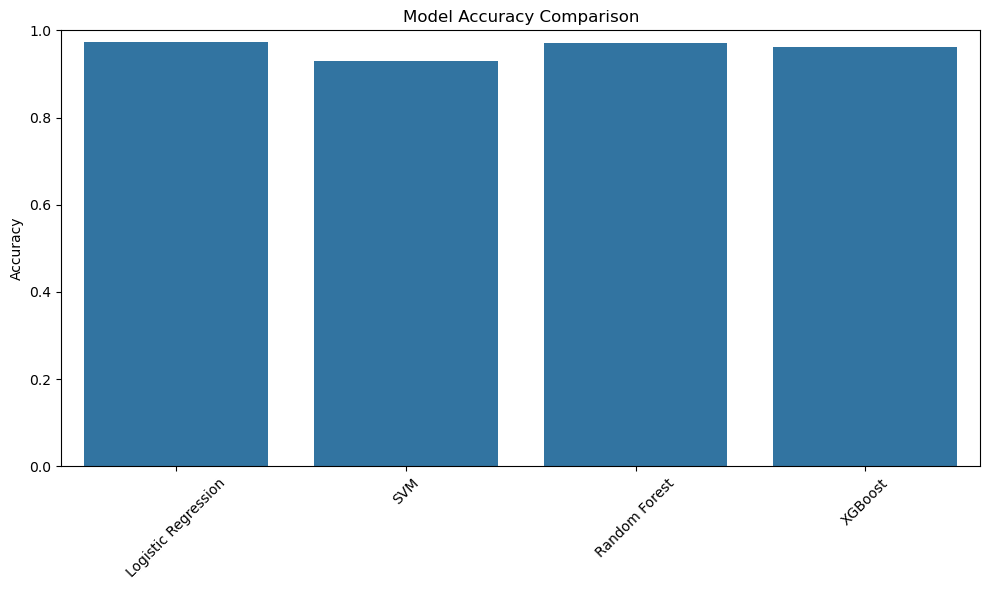

In [69]:
# Visual comparison of model accuracies
accuracies = {
    'Logistic Regression': accuracy_score(y_test, y_pred_lr),
    'SVM': accuracy_score(y_test, y_pred_svm),
    'Random Forest': accuracy_score(y_test, y_pred_rf),
    'XGBoost': accuracy_score(y_test, y_pred_xgb)
}
print(accuracies )
plt.figure(figsize=(10, 6))
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()))
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Total gains and ROI

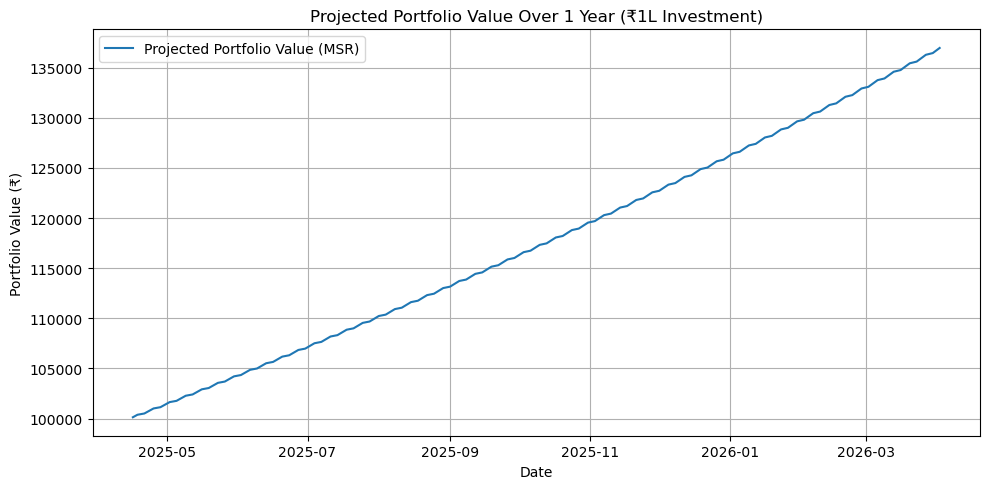

(136979.99999999788, 36979.999999997875, 36.97999999999787)

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Simulate investment scenario
initial_investment = 100000  

# We'll use the average return from MSR earlier mentioned: 0.3698 annual return
# Convert it to daily return: assuming 252 trading days in a year
annual_return_msr = 0.3698
daily_return_msr = (1 + annual_return_msr) ** (1/252) - 1

# Generate a prediction for 1 year
days = 252
predicted_daily_returns = np.full(days, daily_return_msr)

# Calculate cumulative returns
cumulative_returns = (1 + predicted_daily_returns).cumprod()

# Calculate portfolio value over time
portfolio_values = initial_investment * cumulative_returns

# Create a DataFrame for insights
dates = pd.date_range(start='2025-04-16', periods=days, freq='B')  # Business days
investment_df = pd.DataFrame({
    'Date': dates,
    'Predicted Daily Return': predicted_daily_returns,
    'Cumulative Return': cumulative_returns,
    'Portfolio Value (₹)': portfolio_values
})

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(investment_df['Date'], investment_df['Portfolio Value (₹)'], label='Projected Portfolio Value (MSR)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (₹)')
plt.title('Projected Portfolio Value Over 1 Year (₹1L Investment)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Key insights
final_value = portfolio_values[-1]
total_gain = final_value - initial_investment
roi_percent = (total_gain / initial_investment) * 100

final_value, total_gain, roi_percent

